In [1]:
# 
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%capture
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML
from jupyter_plotly_dash import JupyterDash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
import numpy as np
import os
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
from sys import exc_info
from caiman import movie as cmovie
import json
import pickle

def tryexcept(x,default):
    try:
        return eval(x)
    except:
        return default

In [3]:
# autoreload setup
%load_ext autoreload
%autoreload 1
%aimport Regions, physio_def_1, numeric, Automatic

from physio_def_1 import *
from Regions import Regions
from numeric import *
from Automatic import *

In [11]:
# global vars
if "srdjan" not in os.getcwd():
    os.chdir(os.path.expanduser("~"))

if "srdjan" in os.getcwd():
    exampleNpzFile = "../test_data/8gl.npz"
#     exampleNpzFile = "/data/Sandra/2020_05_13/Experiment48b/Experiment48b_0_Series009.npz"
else:
    exampleNpzFile = "/data/Sandra/2020_05_13/Experiment48b/Experiment48b_0_Series009-11.npz"

outputStyle = {
    "color":"blue",
    "font-family":"Courier New",
    "font-size":"90%",
    }
infoStyle = {
    "font-size":"80%",
    "color":"grey",
    }

baseFig = getFigure(w=200,h=150)

## global vars
test = "srdjan" in os.getcwd()
debug = "srdjan" in os.getcwd()

if test:
    %config InlineBackend.figure_format = 'retina'

In [12]:
debug=False

In [13]:
try: del regions0
except: pass
try: del regions
except: pass

In [14]:
app = JupyterDash(__name__,
                  width=1000,
                  height=1000,
                 )

APP_LAYOUT = [
    
    html.H1(children='CaRec Analyzer'),
    html.Div("Please, think of a better name and let me know. :-)",style=infoStyle),
    html.Br(),
    
    html.H3("Import recording"),################################################################################
    
    html.Div('Enter path to a file and press enter.',style={ "display":"inline-box"}),
#     html.Div('If you I will not check for movement, so if you already have a motion-corrected file, input that directly.',style={**infoStyle, "display":"inline-box"}),
    
    dcc.Input(id="filename_input",
            type="text",
            placeholder=exampleNpzFile,
            debounce=True,
            size = 60,
#             value=exampleRoiFile if test else "",
            value=exampleNpzFile if test else "",
        ),

    html.Br(),
    
    html.Div(id="filename_feedback", children="",style=outputStyle),#To start, enter the full path to a file and press enter. Note, that loading can take a few seconds [for very large files even a minute].
    
    html.Div([html.Br(),"Re(set) Frequency to "], style={'display': 'inline-block'}),
    dcc.Input(id="freq_input",
        type="text",
        debounce=True,
        size = 5,
        value="",
        placeholder="3",
        style={'display': 'inline-block', "margin-left":"5px", "margin-right":"5px", "width":"40px"}),    
    html.Div("Hz.",style={'display': 'inline-block'}),
    html.Button("(Re)set frequency", n_clicks=0, id="freq_button",style={"margin-left":"5px"}),
    html.Br(),
    html.Div("[Only if you need override automatic setting, or in the absence of metadata]",
             style={**infoStyle,'display': 'inline-block', "margin-left":"5px"}),

    html.Div(id="freq_feedback", children="",style=outputStyle),
    
    html.H3("Cell detection"),################################################################################
    
    html.Div([
#         "Use the lasso tool in the left figure to define a large region of interest, which is to be further split into individual ROIs corresponding to cells (or their parts). If you do not select anything, the whole movie will be analyzed.",
#         html.Br(),
#         "In the right figure you will see the whole time trace of the part selected from the left figure. Here you can use the slider at the bottom to define a time domain to be analyzed.",
             "Use the slider if you need to select only a part of the movie."],style={'display': 'inline-block'}),
    html.Div("For example, if there is a single distinct movement in the movie, you may want to analyze the two parts separately.", style=infoStyle),
    
#     dcc.Input(id="lasso_out",
#             type="text",
#             debounce=False,
#             size = 60,
#             value="",
#           style={"display":"block" if debug else "none"}
#         ),

    html.Div(children=[
        html.Pre(
        id="relay_out",
        children="relay_out",
        style={
            "vertical-align":"text-top",
            "width"    : "200px",
            "height"   : "50px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
              })
    ],style={"display":"inline-block" if debug else 'none'}),
        
    
#     html.H3(children='ROIs', style=bodyStyle),
    
    html.Br(),
#     html.Div(dcc.Graph(id='roi_selector0', figure=baseFig), style={"display":"inline-block"}),
    html.Div(dcc.Graph(id='FOV_trace',     figure=baseFig), style={"display":"inline-block"}),
    
    html.Br(),
    
    html.Div(children="Time resampling for ROIs", style={'display': 'inline-block', "margin-right":"5px",}),
    dcc.Input(id="time_resample",
        type="text",
        debounce=True,
        size = 5,
        value="10" if debug else "1",
        style={"width":"25px"}
             ),    
    html.Div(children="[Downsample frequency by this fraction.]", style={**infoStyle,'display': 'inline-block', "margin-left":"5px",}),
    html.Br(),
    html.Div(children="Spatial filtering", style={'display': 'inline-block'}),
    dcc.Input(id="gSig_filt_input",
        type="text",
        debounce=True,
        size = 5,
        value=tryexcept("regions.filterSize",""),
        placeholder="3",
        style={"width":"35px", "margin-right":"5px", "margin-left":"5px"}),    

    html.Div(html.Abbr(
        children="[info]",
        title=
        """    For the proper analysis, you need to set the size of the spatial filter. Its value should be of the order of the  half of the typical cell dimension (in pixels!). 
    You can also combine filtering at different scales by inputing a list of two (or more) integers. For example, '[5,3]' will combine filtering at 5 and at 3. Sometimes this capures better the finer structure."""
        ),style={**infoStyle,'display': 'inline-block', "margin-right":"35px"}),
#     html.Br(),
    html.Button("Calculate ROIs", n_clicks=1 if  debug else 0, id="rois_button"),
    html.Div(id="rois_feedback", children="",style=outputStyle),

    html.Br(),
    
    html.Div(dcc.Graph(id='roi_selector', figure=baseFig), style={"display":"inline-block"}),
    html.Div(children = [
        dcc.Graph(id='show_hover_trace',figure=baseFig),
        html.Div([
            dcc.Checklist(
                id="show_filtered_choice",
                options=[{"label":'Show filtered with offset',"value":"yes"}],
                value=[],
#                 labelStyle={'vertical-align': 'center'},
                style={"display":"inline-block","verticalAlign":'middle'},
                ),
            dcc.Input(id="offset_input", size=5, value="1", type="text",style={"display":"inline-block","width":"20px","verticalAlign":'middle'})
        ], style={**infoStyle,"display":"inline-block","text-align":"right"},),
             ], style={"display":"inline-block","text-align":"right"},),
    html.Br(),
    
    html.Div(children=[
        html.Pre(
        id="selected_out",
        children="selected_out",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll'
              }),
        html.Pre(
        id="hover_out",
        children="hover_out",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
              })
    ],style={"display"  : "inline-block" if debug else "none"}),
    
    
    html.Div(children=
        html.Pre(
        id="spare_out",
        children="spare",
        style={
            "vertical-align":"top",
            "width"    : "200px",
            "height"   : "100px",
            'border'   : 'thin lightgrey solid',
            'overflowY': 'scroll',
            "display"  : "inline-box"
              }),
             style={"display":"inline-block" if debug else "none"}),
    
#     html.Div([
#         "Show downsampled to",
#         dcc.Input(id="show_freq_input",
#             type="text",
#             debounce=False,
#             size = 3,
#             value='30'),
#         "Hz"
#         ], style={ }, ),
    
    html.Br(),
    html.Div(children=[
        "Show filtered for spikes shorter than",
        dcc.Input(id="filter_input",
            type="text",
            debounce=True,
            size = 5,
            placeholder="e.g. 3",
            value="",
            style={"margin-right":"5px", "margin-left":"5px","width":"35px"}),
        "seconds."
    ],
             style={ 'display': 'inline-block', "margin-right":"5px"}),
    
    html.Button("Filter", n_clicks=0, id="filter_button"),
    
    html.Div(children=" ", id="filter_feedback",
             style={'display': 'inline-block',**outputStyle}),
    html.Br(),
    html.Div([
       "Selected ROIs:",
        dcc.Input(id="selected_indices",
            type="text",
            debounce=True,
            size=60,
            value="",
         ), 
        html.Button('Discard unselected', id='discard_button', style={"display":"inline-box"},
                    n_clicks=1
                   ),
        html.Div(id="discard_feedback",children="",
             style={"display":"inline-box",**outputStyle,
#                     "width":100
                   }
            )
    ],style={"display":"inline-box"}),
    
    
#     html.Div([
#     html.Button('Plot selected', id='plot_selected_button', style={"display":"inline-box"},
#                 n_clicks=0
#                ),
#         html.Div("... with offset: ", style={"display":"inline-block"}),
#         html.Div(dcc.Input(id="offset_input",
#             type="text",
#             debounce=False,
#             size=3,
#             value='1'), style={"display":"inline-block"}),
#         html.Div("(only when showing filtered)", style={**infoStyle,"display":"inline-block"}),
#     ]),
    
    
#     html.Div(dcc.Graph(id='show_selected_traces',figure=getFigure(h=10,w=700))),
    

# #     # html.Div([
# #     #     "Save tag to selected rois: ",
# #     #     dcc.Input(id="tag_save",
# #     #         type="text",
# #     #         debounce=False,
# #     #         size = 30,
# #     #         placeholder="e.g. beta, alpha, edge, central...",
# #     #         value=''),
# #     #     html.Div("save_tag_feedback",style=outputStyle,id="save_tag_feedback"),
# #     # ]),
    
    
    html.H3("Save all"),
    html.Div([
        "When you are happy with your analysis, you can save it. By default, the analysis (traces and coordinates) is saved as the current date (e.g. 2020_02_18) in the directory",
        html.Div("",style=outputStyle,id="analysis_folder"),
        "You can modify the filename by adding to it some other identifier(s) by entering them in the input box below. I suggest your username.",
        "When you are ready, press save."
        "Note also that the traces and times will be saved with the frequency close (yet not necessarily the same) to the one given in the field 'Show downsampled'. "
    ]),
    dcc.Input(id="save_file_append",
        type="text",
        debounce=False,
        size = 30,
        placeholder="e.g. username",
        value='',style={"display":"inline-box"}),
    html.Button('Save', id='save_button', style={"display":"inline-box"},
                n_clicks=0
               ),
    html.Div(id="save_feedback",
             style={"display":"inline-box",**outputStyle}
            )
    ]

In [15]:
def loadNpzFiles(val, dryrun=False, reimport=True):
    from pandas import read_csv
    npzFile = val
    analysisFolder = npzFile.replace(".npz","_analysis")
    feedback = []
    if reimport:
        if "Series" in npzFile:
            serrange = npzFile.rstrip(".npz").split("Series")[1].split("-")
            serrange = [int(el) for el in serrange]
            singleFile = len(serrange)==1
        else: singleFile = True
        if singleFile:
            if dryrun:
                movie = np.zeros((100,10,10))
            else:
                movie = import_npz_files([npzFile])
            feedback += [
                f"{npzFile} loaded successfully.",
                html.Br(),
            ]
        else:
            if len(serrange)>2:
                feedback += ["Expecting only two numbers (beginning and end), but got more than that. Proceeding with the first and the last. "]
            serrange = range(serrange[0],serrange[-1]+1)
            ianchor = int(os.path.split(val)[1].split("_Series")[0].split("_")[-1])
            npzFiles = [(npzFile.split("Series")[0]+"Series%03i.npz"%i).replace(f"_{ianchor}_", f"_{ianchor+ia}_") for ia,i in enumerate(serrange)]
            if dryrun:
                movie = np.zeros((100,10,10))
            else:
                movie = import_npz_files(npzFiles)
            for f in npzFiles:
                feedback += [
                    f"{f} loaded successfully.",
                    html.Br(),
                ]
        movie = movie.astype("float")
        if len(movie.shape)==2:        
            movie = movie.reshape((1,-1))
        movie = cmovie(movie)

    try:
        if singleFile:
            metadata = read_csv(npzFile.replace("npz","txt")).loc[0]
        else:
            feedback += ["Assuming the metadata for all recording are the same, and importing it from the first recording only.",
                    html.Br(),]
            metadata = read_csv(npzFiles[0].replace("npz","txt")).loc[0]
        movie.fr = metadata.freq
        timeframes = metadata['T']
        if singleFile: assert timeframes==len(movie)
        freq = metadata.freq
        pxsize = metadata.pxSize
        feedback += [
            f"Info from metadata: frequency {freq:.4} Hz, and pixel size {pxsize:.3} µm. ",
            f"Movie shape is {movie.shape}. "
        ]
        if pxsize<1:
            feedback += [
            f"This is too tiny pixel, so I will decrease the resolution to increase the pixel size twice to {(2*pxsize):.3} µm. ",
            ]
            movie = rebin(rebin(movie, 2, axis=1, norm=False), 2, axis=2, norm=False)
            pxsize *= 2
        outFilterSize = str(int(np.ceil(6./pxsize)))
        feedback += [
            html.Br(),
            f"Automatic size of the spatial filter based on the pixel size: {outFilterSize} [you can change it below] ",
            html.Br(),]
    except:
        feedback += [
            f"WARNING: Missing medatada. I will assume a frequncy of 1Hz for the first setup.",
            "In case you actually know the frequency, you can change it down."
            "Also, think carefully about the size of the spatial filter. See hover info.",
        html.Br(),
        ]
        outFilterSize = None
        freq = 1

    movie.fr = freq


#     # resample temporarily to lower frequency, to initiate ROIs and check for motion correction
#     if freq>3:

#         freqMC = 3
#         n_rebin = int(movie.fr/freqMC)

#         rebinned_movie = rebin(movie,n_rebin).astype("float32")
#         rebinned_movie = cmovie(rebinned_movie)
#         rebinned_movie.fr = movie.fr/n_rebin
#     else:
#         rebinned_movie = movie.astype("float32")

    # initiate ROIs
    regions = Regions(movie, full=False, diag=True)
    del regions.statImages["diff_mean"]
    regions.movie = movie
    regions.file = val
    regions.trange = regions.time[0], regions.time[-1]
    regions.analysisFolder = analysisFolder
    try: regions.metadata = metadata
    except: pass

    return (feedback, outFilterSize, regions)

In [16]:
######################################################################################
@app.callback([Output("filename_feedback", "children"),
               Output("gSig_filt_input", "value"),
               Output("freq_input", "value"),
               Output("analysis_folder","children"),
#                Output("roi_selector0", "figure"),
               Output("FOV_trace", "figure")
              ],
              [Input("filename_input", "value")],
#               [State("check_movement_choice","value")]
             )
def loadFiles_callback(val):
    if str(val)=="":
        return ('Loading can take a some time [for very large files even minutes].',"","","",baseFig)
    try:
        global regions
        if val.endswith(".npz"):
            feedback, filterOut, regions = loadNpzFiles(val)
            freqOut, analysisFolder = regions.movie.fr, regions.analysisFolder
        
        if val.endswith(".roi") or val.endswith(".pkl"):
            return (["Sorry, importing pickles is not yet supported."], "", "", "",baseFig)
        
        regions.get_fov_trace()
        fovTrace = fov_trace(regions, twoRows=False) 
        
        return (feedback, filterOut, freqOut, analysisFolder,fovTrace)
            
    except:
        return ([html.P("ERROR: "+exc_info().__repr__())], "", "", "", baseFig)


In [17]:
######################################################################################
@app.callback(
    Output("freq_feedback", "children"),
    [Input("freq_button", "n_clicks")],
    [State("freq_input", "value")]
             )
def resetFreq_callback(n_clicks,newfreq):

    try:
        if n_clicks <= 0:
            return ""
        else:
            global regions
            newFreq = float(newfreq)
            regions.time = np.arange(len(regions.movie))/newFreq
            regions.movie.fr = newFreq
            return "Movie frequency set to %.1f Hz"%newFreq
    except:
            return "ERROR: "+exc_info().__repr__()

In [18]:
@app.callback([
    Output("rois_feedback", "children"),
    Output("roi_selector","figure"),
#     Output("time_resample", "value"),
    ],
    [Input("rois_button", "n_clicks")],
    [
    State("gSig_filt_input", "value"),
    State("time_resample", "value"),
    State("relay_out", "children"),
    ]
             )
def rois_callback(n_clicks,spFilt,time_resample,relayOut):
    feedback = []
    try:
        if n_clicks <= 0 or len(spFilt)==0:
            return "", baseFig
        else:
            global regions
            
        feedback = []
        x = eval(spFilt)
        if type(x) == int:
            x = [x]
        
        update = 0
        
        if len(relayOut) and relayOut!="relay_out":
            t_begin, t_end = eval(relayOut)["xaxis.range"]
        else:
            t_begin, t_end = regions.time[0], regions.time[-1]
        
        if regions.trange != (t_begin, t_end):
            update += 1
            feedback += ["Time range changed.",html.Br()]
        
        try:
            regions.filterSize
            if sorted(regions.filterSize) != sorted(x):
                update += 1
                feedback += [f"Filter has changed to {x}.",html.Br()]
        except:
            update += 1
            feedback += [f"Filter set to {x}.",html.Br()]
        
        
    
        nRebin = int(time_resample)
        if nRebin<=0: nRebin = 1
        if nRebin != regions.nRebin:
            update += 1
            feedback += [f"Downsample factor changed from {regions.nRebin} to {nRebin}.",html.Br()]
            
            
        if update:
            time = np.arange(len(regions.movie))/regions.movie.fr
            i_begin = np.where(time>=t_begin)[0][0]
            i_end = np.where(time<=t_end)[0][-1]
#             movie = rebin(regions.movie[i_begin:i_end], time_resample)
#             movie.fr = regions.movie.fr/time_resample
            regions = createRegions(regions.movie, gSig_filt=x,diag=True, nRebin=nRebin, FrameRange = (i_begin, i_end))
#             regions.time = np.arange(len(movie))/movie.fr
            regions.trange = regions.time[0], regions.time[-1] 
            # merge obvious ROIs
            from Regions import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph
            while True:
                peak2bnd = getPeak2BoundaryDF(regions.df)
                df = peak2bnd.query("dist<1.")[["i","j"]]
                if len(df)==0: break
                gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)
                dropped = mergeBasedOnGraph(gRois,regions)
                if dropped == 0: break

            regions.purge_lones((min(x)*.5)**2)
            regions.sortFromCenter()
        im = regions.statImages["diff_std"]
        feedback += [f" Number of ROIs: {len(regions.df)}"]
        roisImage = showRoisOnly(regions,indices=regions.df.index,im=im)
        return feedback, roisImage

    except:
        feedback+=["ERROR: "+exc_info().__repr__(),str((n_clicks,spFilt,relayOut,time_resample))]
        return feedback, baseFig
    

In [19]:
@app.callback(
    Output("selected_out", "children"),
    [Input("roi_selector", "selectedData")],
    )
def showSelected(selData):
    try:
        if selData is None:
            return "selected_out"
        return json.dumps(selData, indent=2)
    except:
        return "ERROR from showSelected: "+exc_info().__repr__() 
    
@app.callback(
    Output("hover_out", "children"),
    [Input("roi_selector", "hoverData")],
    )
def showHovered(hoverData):
    try:
        if hoverData is None:
            return "hover_out"
        return json.dumps(hoverData, indent=2)
    except:
        return "ERROR from showHovered: "+exc_info().__repr__()


@app.callback(
    Output("selected_indices", "value"),
    [Input("roi_selector", "selectedData")]
)
def collectSelected(selData):
    try:
        out = np.unique([pt["hovertext"] for pt in selData["points"]])
        out = sorted(out,key=int)
        return ", ".join(out)
    except:
        return "" 


@app.callback(
#      Output("roi_selector", "figure"),
     Output("discard_feedback", "children"),
    [Input("discard_button",   "n_clicks")],
    [State("selected_indices", "value")]
             )
def discard_callback(n_clicks,selected):
    try:
        if n_clicks <= 0:
            return ""

        global regions
        if selected == "":
            out = "nothing selected."
        else:
            selectedIndices = np.array(list(eval(selected)))
            nremoved = len(regions.df)-len(selectedIndices)
            regions.df = regions.df.loc[selectedIndices]
            out = "%i rois removed. Please, press again the button to 'Calculate Rois', to replot the remaining rois."%(nremoved)

#         roisImage = showRoisOnly(regions,indices=regions.df.index,im=regions.statImages["diff_std"])
#         if narrowHover:
#             roisImage.update_layout({"width":220,"height":240})
        return out
    except:
        return "ERROR: "+exc_info().__repr__()

In [20]:

######################################################################################
@app.callback(
    Output("relay_out", "children"),
    [Input("FOV_trace", "relayoutData")],
    )
def showRelayoutData(relData):
    try:
        if relData is None:
            return "relay_out"
        return json.dumps(relData, indent=2)
    except:
        return "ERROR from showRelayoutData: "+exc_info().__repr__() 

In [21]:
@app.callback(
    Output("filter_feedback", "children"),
    [Input("filter_button", "n_clicks")],
    [State("filter_input", "value")]
             )
def filter_callback(n_clicks, val):
    try:
        if n_clicks <= 0:
            return ""
        if val == "" or val is None:
            feedback = ""
        else:
            global regions
            timeScale = float(val)
            try: del regions.df["filteredTrace"]
            except: pass
            feedback = "You chose to discard all features longer than approximately %g seconds."%timeScale
            if "faster_%g"%timeScale not in regions.df:
                regions.fast_filter_traces(timeScale, order=6)
            regions.df["filteredTrace"] = regions.df["faster_%g"%timeScale]
#             regions.df["filteredTrace_slow"] = regions.df["faster_%g"%timeScale]
#             for col in regions.df.columns:
#                 if "show" in col:
#                     del regions.df[col]
            feedback += " Filtering successful."
        return feedback
    except:
        return "ERROR: "+exc_info().__repr__()

In [22]:
@app.callback(
    Output("show_hover_trace", "figure"),
    [Input("roi_selector", "hoverData"),
     Input("roi_selector", "selectedData"),
    ],
    [State("show_filtered_choice", "value"),
     State("offset_input", "value"),
    ])
def plotHovered_callback(hoverData, selData, showFiltered, offset):
    from dash import no_update
    try:
        global regions
        try:
            hoverData.dtype
            ix = hoverData
        except:
            try:
                ix = [int(hoverData["points"][0]["hovertext"])]
            except:
                ix = []
        try:
            selData = np.unique([int(pt["hovertext"]) for pt in selData["points"]])
            ix = np.unique(np.hstack([selData, ix]))
        except:
            pass
        if len(ix)>10:
            return no_update
        if len(showFiltered):
            cols = ["filteredTrace"]
            offset = float(offset)
        else:
            cols = ["trace"]
            offset = 0
        trfig = plotTraces(regions,indices=ix, showCol=cols, offset=offset)#,time=regions.showTime[colToshow], showCol=showCol)
#         trfig.layout.update()
#         if narrowHover:
#         trfig.update_layout({"width":220,"height":200})
        return trfig
    except:
        return no_update


In [23]:
@app.callback(
    Output("save_feedback", "children"),
    [Input("save_button", "n_clicks")],
    [State("save_file_append", "value"   ),
#      State("show_freq_input", "value"),
     State("analysis_folder","children"),
     State("show_filtered_choice", "value")
    ]
             )
def save_callback(n_clicks,filename, outDir, showFiltered):

    try:
        if n_clicks <= 0:
            return "saving can take a few seconds."
        global regions
        if len(showFiltered):
            col = "filteredTrace"
        else:
            col = "trace"
        regions.showTime = regions.time
        return saveRois(regions, outDir, filename, col=col)
    except:
            return "ERROR: "+exc_info().__repr__()+"\n"+str((n_clicks,filename, outDir, showFiltered))

In [25]:
app.layout = html.Div(children=APP_LAYOUT, style={"font-family":"Arial"})
app

In [18]:
app.layout = html.Div(children=APP_LAYOUT, style={"font-family":"Arial"})
app._repr_html_() 
link2app = "https://ctn.physiologie.meduniwien.ac.at"+app.get_app_root_url()
HTML(f'open the following link in a different tab (do not close this tab!): <a href="{link2app}">{link2app}</a>')

# Irrelevant

In [161]:
t = regions.time

In [294]:
regions.nRebin

10

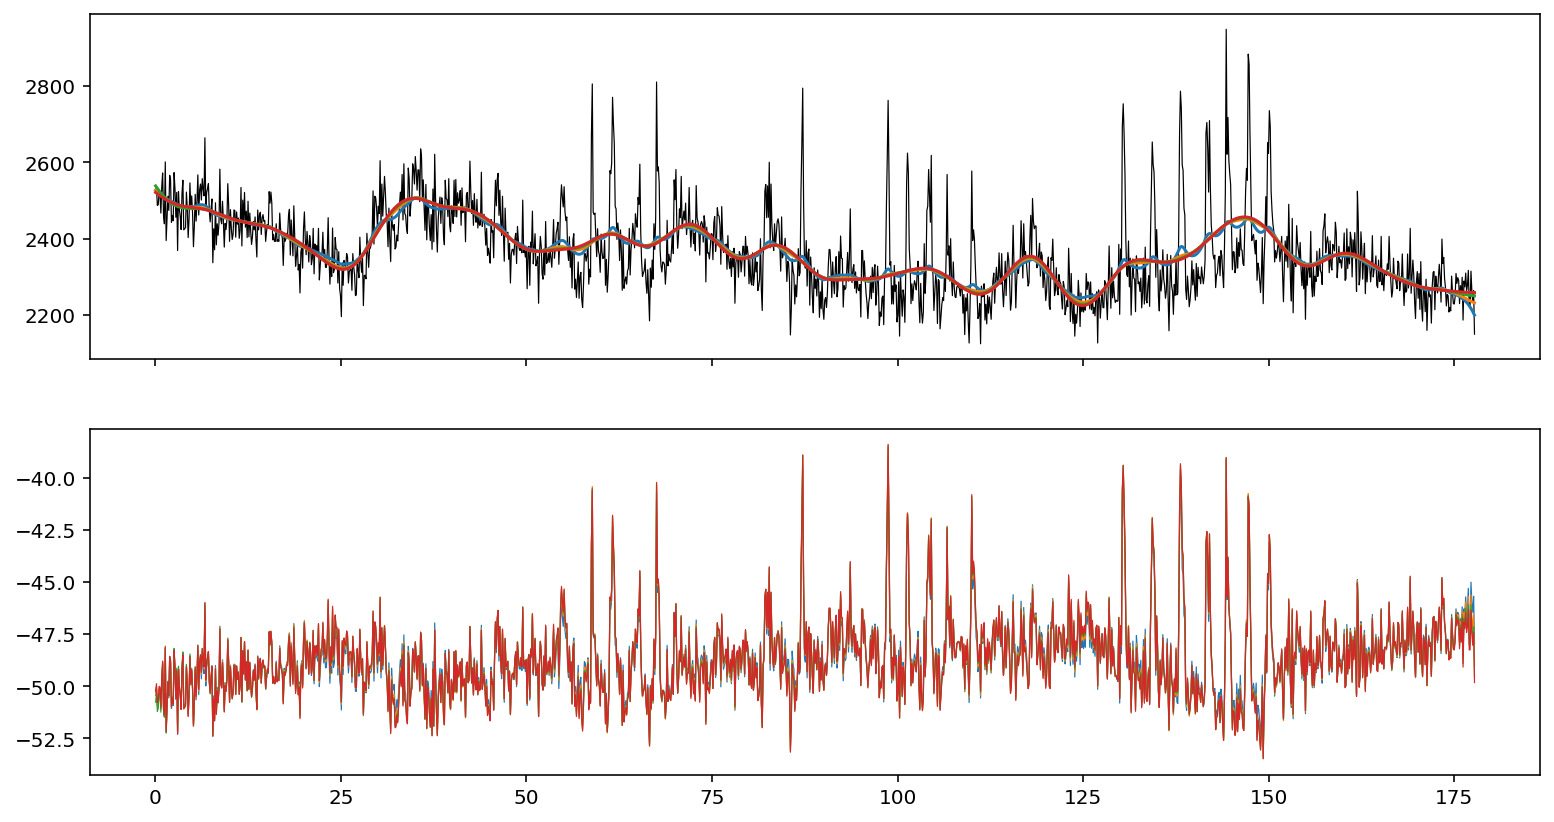

In [295]:
ts = 1
i = 27
k = regions.df.loc[i,"size"]*regions.nRebin
x = regions.df.loc[i,"trace"]*k
fig, axs = plt.subplots(2,1,figsize=(13,7), sharex=True)
axs[0].plot(t, x, lw=.6, color="k")
# xs = []
for o in range(1,5):
    regions.fast_filter_traces(ts, order=o, z_sp=0)
    xs = regions.df.loc[i,"slower_%g"%ts]*k
    xf = regions.df.loc[i,"faster_%g"%ts]*k
    z = (xf-xs)/xs**.5
    c = axs[0].plot(t,xs)[0].get_color()
    axs[1].plot(t,z, lw=.6)
#     axs[1].axhline(o-1, lw=.5,color=c)
    
# plt.xlim(90,130)

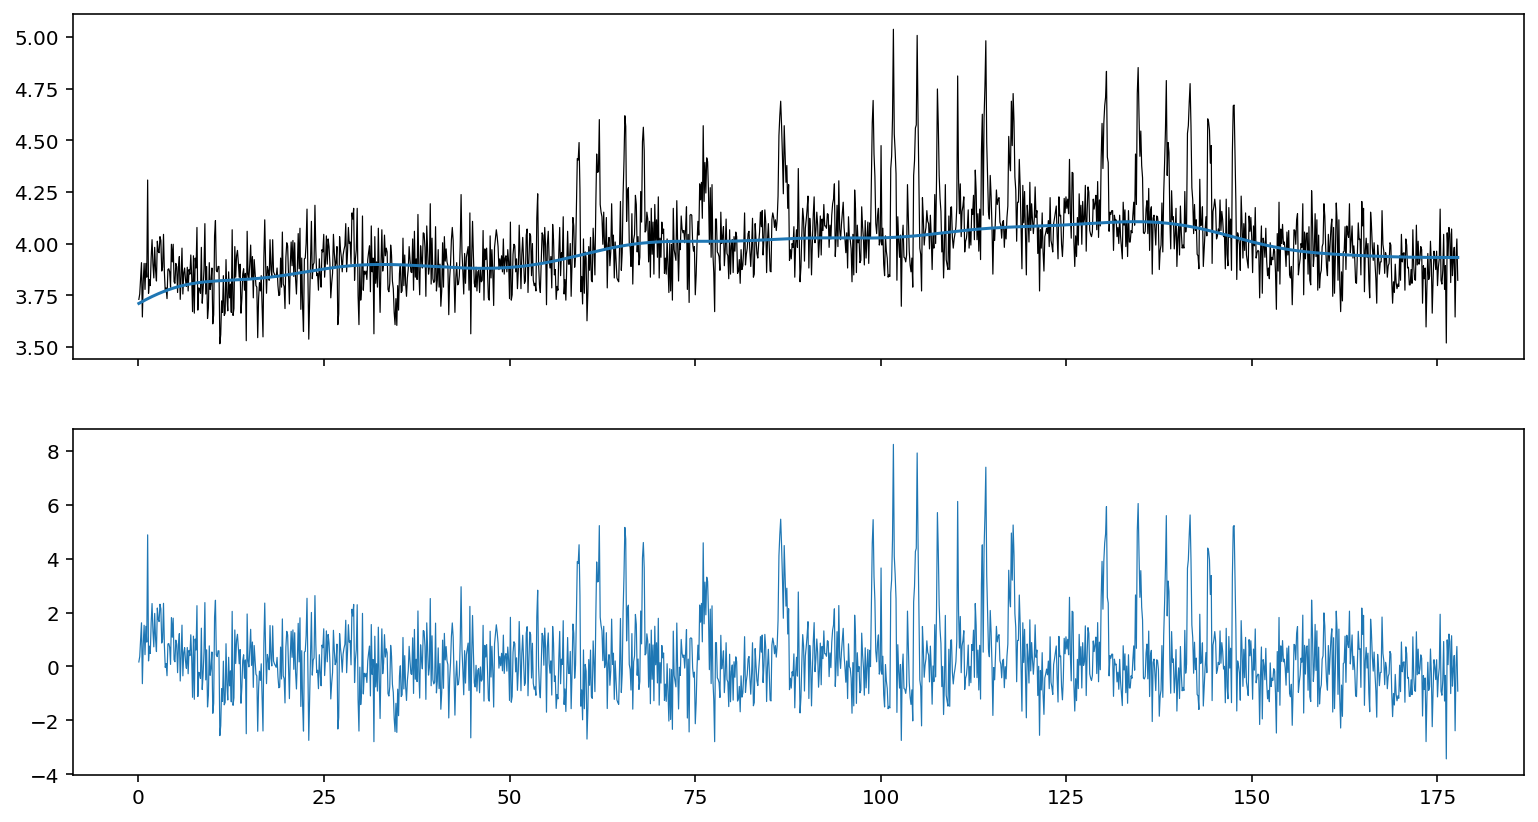

In [384]:
ts = 3
i = 107
k = 1#regions.df.loc[i,"size"]*regions.nRebin
x = regions.df.loc[i,"trace"]*k
fig, axs = plt.subplots(2,1,figsize=(13,7), sharex=True)
axs[0].plot(t, x, lw=.6, color="k")
# xs = []
for o in range(4,5):
    regions.fast_filter_traces(ts, order=o, z_sp=2)
    xs = regions.df.loc[i,"slower_%g"%ts]*k
    xf = regions.df.loc[i,"faster_%g"%ts]*k
    z = regions.df.loc[i,"zScore_%g"%ts]*k
#     z = (xf-xs)/xs**.5
    c = axs[0].plot(t,xs)[0].get_color()
#     axs[1].plot(t,xf+o-1, lw=.6)
#     axs[1].axhline(o-1, lw=.5,color=c)
    axs[1].plot(t,z, lw=.6)
    
# plt.xlim(90,130)

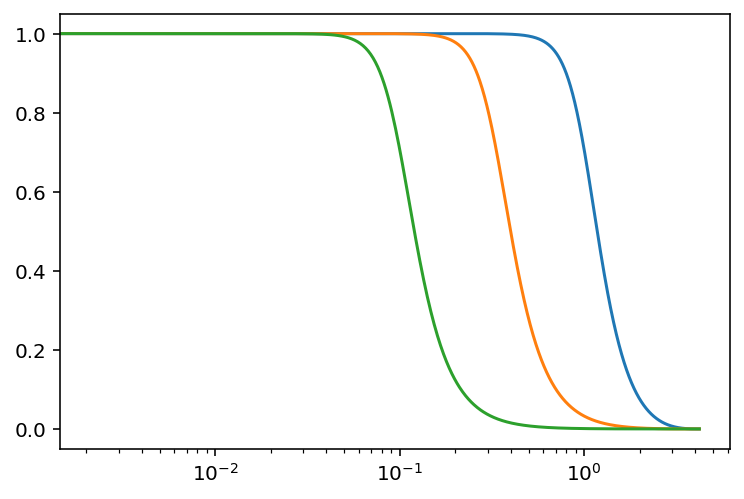

In [422]:
for ts in [1,3,10]:
    regions.fast_filter_traces(ts, order=3)
    plt.plot(*regions.sosFilter.get_shape())
plt.xscale("log")

In [424]:
for c in regions.df.columns:
    if "fast" in c.lower(): del regions.df[c]
    if "slow" in c.lower(): del regions.df[c]
    if "zscore" in c.lower(): del regions.df[c]

(50, 80)

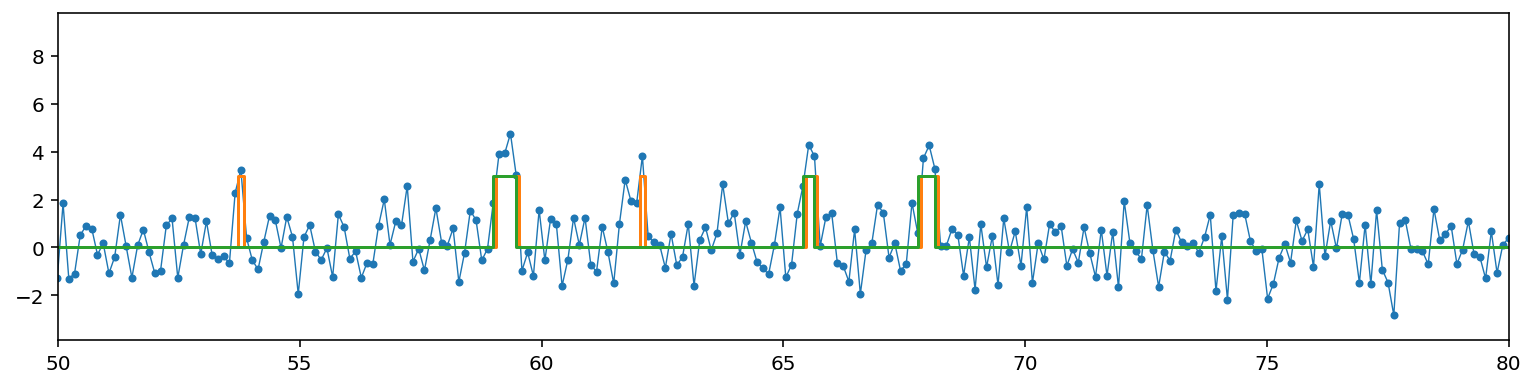

In [445]:
ts = 3
regions.calc_raster(ts,z_th=3)
for i in [107]:
    plt.figure(figsize=(13,3))
    plt.plot(t, regions.df.loc[i,"zScore_%g"%ts], ".-",lw=.7)
    rdr = regions.raster[ts][i]
    plt.step(t, rdr*3, where="mid")
    rdr1 = runningAverage(rdr.astype(float),3)>.5
    rdr1 = rdr1.astype("int")
    plt.step(t, rdr1*3)
plt.xlim(50,80)

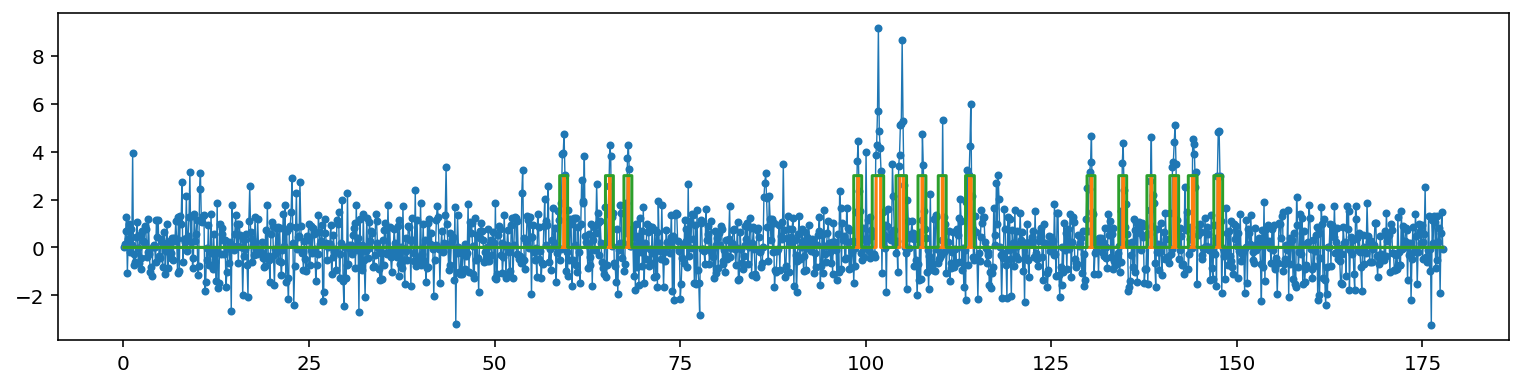

In [439]:
ts = 3
regions.calc_raster(ts,z_th=4)
for i in [107]:
    plt.figure(figsize=(13,3))
    plt.plot(t, regions.df.loc[i,"zScore_%g"%ts], ".-",lw=.7)
    rdr = regions.raster[ts][i]
    plt.step(t, rdr*3, where="mid")
    rdr1 = runningAverage(rdr,9)>.5
    rdr1 = rdr1.astype("int")
    plt.step(t, rdr1*3)
# plt.xlim(75,150)

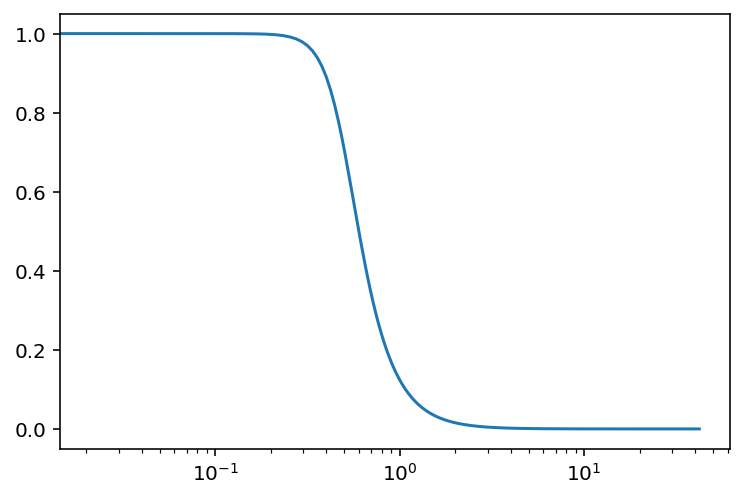

In [416]:
plt.plot(*regions.sosFilter.get_shape())
plt.xscale("log")

In [ ]:
from 

In [403]:
regions.sosFilter.__dict__

{'sos_pars': array([[ 6.23285967e-06,  1.24657193e-05,  6.23285967e-06,
          1.00000000e+00, -9.63415048e-01,  0.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00, -1.96206458e+00,  9.63427514e-01]]),
 'frequency': 84.31013032470835}

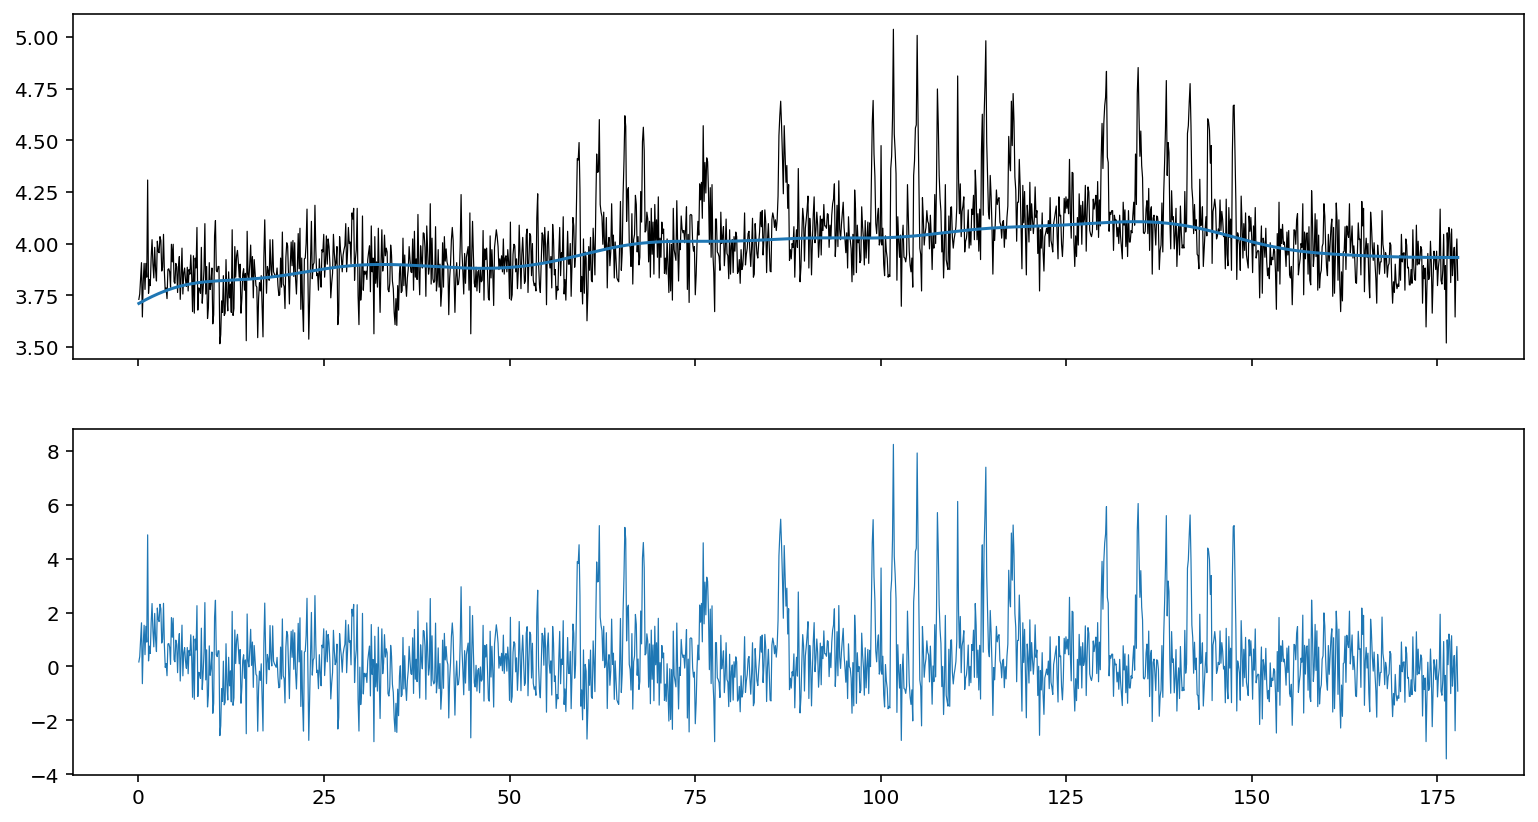

In [384]:
i = 107
k = 1#regions.df.loc[i,"size"]*regions.nRebin
x = regions.df.loc[i,"trace"]*k
fig, axs = plt.subplots(2,1,figsize=(13,7), sharex=True)
axs[0].plot(t, x, lw=.6, color="k")
# xs = []
for o in range(4,5):
    regions.fast_filter_traces(ts, order=o, z_sp=2)
    xs = regions.df.loc[i,"slower_%g"%ts]*k
    xf = regions.df.loc[i,"faster_%g"%ts]*k
    z = regions.df.loc[i,"zScore_%g"%ts]*k
#     z = (xf-xs)/xs**.5
    c = axs[0].plot(t,xs)[0].get_color()
#     axs[1].plot(t,xf+o-1, lw=.6)
#     axs[1].axhline(o-1, lw=.5,color=c)
    axs[1].plot(t,z, lw=.6)
    
# plt.xlim(90,130)

In [377]:
regions.calc_raster(3,z_th=4)

In [378]:
raster = regions.raster[3]

In [379]:
raster[:,0] = False
raster[:,-1] = False

In [380]:
draster = np.diff(raster.astype(np.int8), axis=1)

In [381]:
[np.where(dr==-1)[0]-np.where(dr==1)[0] for dr in draster]

[array([2, 1, 1, 3, 2, 4, 2, 4, 4, 3, 3, 2, 4, 3, 1, 3, 2, 1, 2, 3, 1]),
 array([2, 3, 2, 4, 1, 4, 3, 5, 4, 2, 2, 2, 3, 1, 5, 3, 1, 1, 2, 2, 1, 3,
        1, 3]),
 array([5, 5, 4, 5, 5, 1, 5, 7, 5, 4, 1, 4, 1, 5, 5, 4, 1, 6, 6, 5, 5, 6,
        1, 5]),
 array([2, 2, 3, 1, 3, 3, 4, 6, 5, 1, 3, 2, 4, 3, 3, 3, 4, 4, 2, 1, 1, 5,
        4, 5, 4]),
 array([1, 2, 3, 1, 3, 1, 3, 1, 2, 2, 2, 4, 2, 3, 1, 3, 1, 2, 1, 1, 1]),
 array([1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 2, 2, 4, 1, 2, 2]),
 array([1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1]),
 array([3, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1]),
 array([4, 4, 4, 3, 5, 6, 4, 2, 6, 3, 4, 3, 3, 1, 4, 5, 6, 4, 4, 5, 4]),
 array([2, 2, 2, 1, 4, 1, 3, 1, 4, 1, 1, 1, 2, 1, 2, 4, 3, 1, 2, 1, 4, 3,
        3]),
 array([], dtype=int64),
 array([2, 1, 2, 2, 4, 2, 3, 2, 1, 2, 1, 1, 2, 2, 1]),
 array([1, 1, 1, 4, 4, 1, 2, 3, 6, 2, 3, 2, 1, 1, 3, 2, 1, 3, 5, 4, 1, 2,
        2, 2]),
 array([1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 6, 2, 1, 1, 4, 1, 1, 2, 1]),
 array([1, 1, 1, 2, 1, 1, 1]),
 array

In [ ]:
begins = np.where(draster==1)[0]

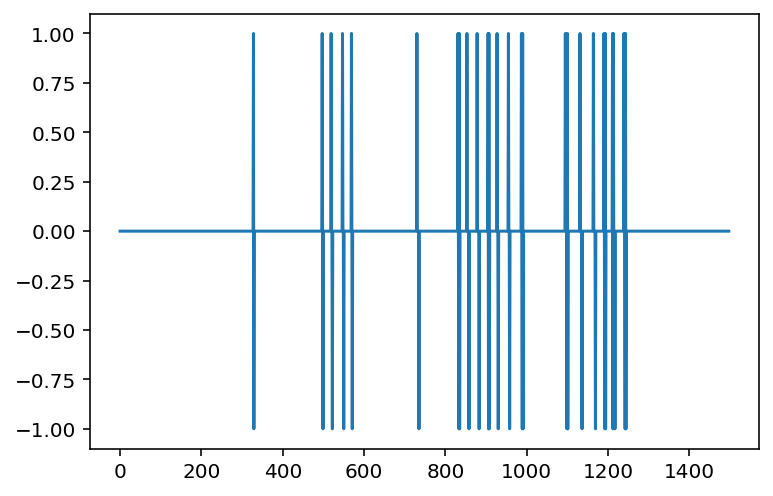

In [369]:
plt.plot(draster[0])

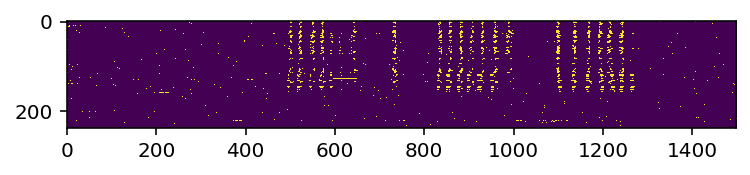

In [351]:
plt.imshow(regions.raster[3])

In [347]:
raster = np.vstack(C["zScore_%g"%ts])>3

In [342]:
x,y = power_spectrum(np.diff(, axis=1), fr=regions.movie.fr/regions.nRebin)

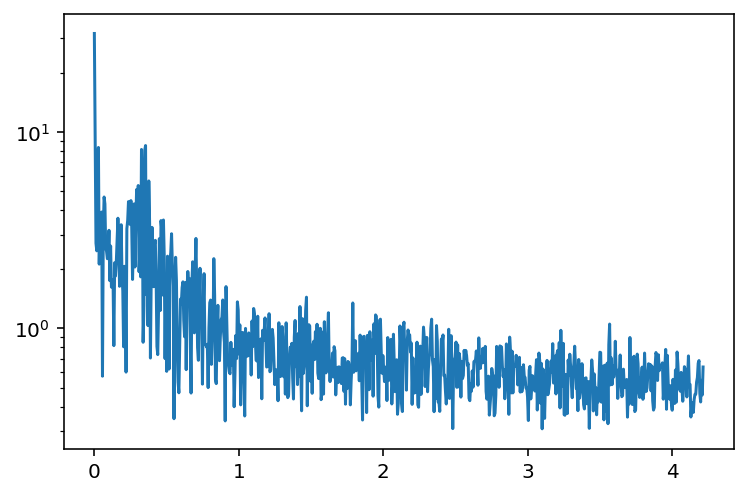

In [346]:
plt.plot(x,np.abs(y)+.3)
plt.yscale("log")

In [312]:
tRebin = int(regions.movie.fr*ts/60)
if tRebin==0: tRebin=1
tRebin

1

In [313]:
time = rebin(regions.time, tRebin)

In [314]:
Nrois = len(regions.df)

In [315]:
C = regions.df

In [316]:
x = rebin(np.vstack([C["faster_%g"%ts][j]*C["size"][j] for j in range(Nrois)]),tRebin,axis=1,norm=False)*regions.nRebin

In [317]:
x_slow = rebin(np.vstack([C["slower_%g"%ts][j]*C["size"][j] for j in range(Nrois)]),tRebin,axis=1,norm=False)*regions.nRebin

In [318]:
x.shape, time.shape

((238, 1499), (1499,))

In [319]:
width = 7
varSample = []

for i in range(Nrois):
    for j in range(width,len(time)-width,len(time)//100+1):
        varSample += [(x_slow[i,j], x[i,j-width:j+width].var())]

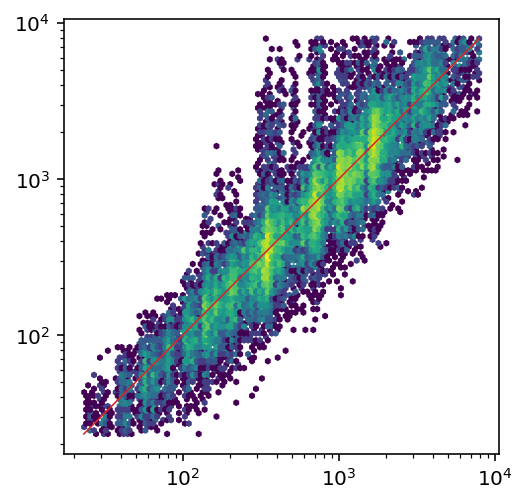

In [320]:
ax = plt.subplot(111)
meanEst, varEst = np.array(varSample).T
vmax = np.percentile(meanEst,99.5)
vmin = max(.1,np.percentile(meanEst,.05))
varEst[varEst>vmax] = np.nan
meanEst[meanEst>vmax] = np.nan
varEst[varEst<vmin] = np.nan
meanEst[meanEst<vmin] = np.nan
ax.hexbin(meanEst, varEst, mincnt=1,bins="log", #gridsize=(100,100),
          xscale="log", yscale="log"
         )
# plt.ylim(0,10)
ax.set_aspect("equal")
plt.plot([vmin,vmax],[vmin,vmax],"C3-",lw=.8)
# ax.set_yscale("log")
# ax.set_xscale("log")

In [321]:
zScore = x/(vmin+x_slow)**.5

In [322]:
i = 0

In [323]:
C.loc[i,"size"]

10

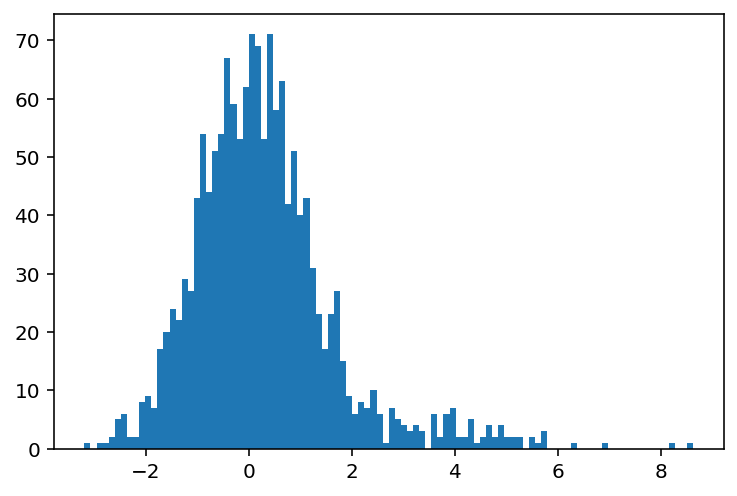

In [327]:
plt.hist(zScore[107],100);

In [325]:
x.shape

(238, 1499)

In [211]:
xcut = x.copy()

In [215]:
from cv2 import dilate, erode

In [290]:
zRaster = (zScore>2).astype("uint8")
# zRaster = erode(zRaster,np.ones(3, dtype = np.uint8).reshape(1,-1))
zRaster = dilate(zRaster,np.ones(5, dtype = np.uint8).reshape(1,-1))

In [291]:
# plt.imshow(zRaster)
# plt.gca().set_aspect("auto")

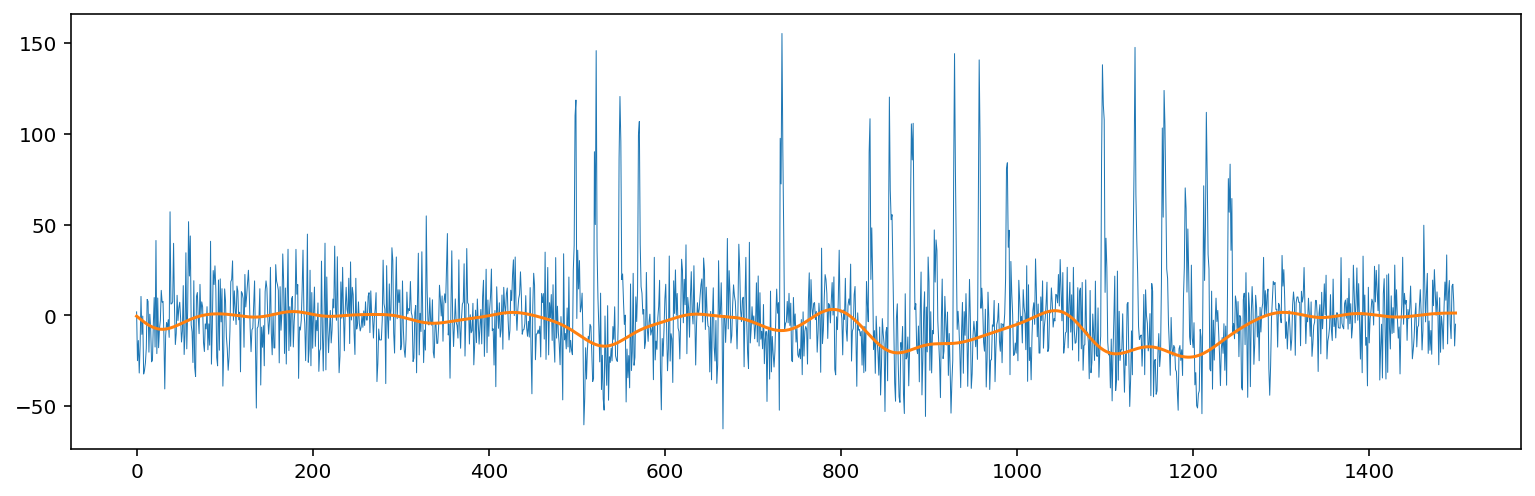

In [292]:
x1 = x.copy()
x1[zRaster.astype(bool)] = np.nan

plt.figure(figsize=(13,4))
plt.plot(x[i],lw=.5)
# plt.plot(x1[i],lw=.5)
y = x1[i].copy()
nans, xx= nan_helper(y)
y[nans]= np.interp(xx(nans), xx(~nans), y[~nans])

y = regions.sosFilter.run(y)
plt.plot(y,lw=1.5)
# y[~zRaster[i].astype("bool")] = np.nan
# plt.plot(y,lw=1.5)

In [264]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [269]:
y= np.array([1, 1, 1, np.nan, np.nan, 2, 2, np.nan, 0])
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])
y.round(2)

array([1.  , 1.  , 1.  , 1.33, 1.67, 2.  , 2.  , 1.  , 0.  ])

In [240]:
np.abs(zRaster1-zRaster).max()

0

TypeError: unhashable type: 'numpy.ndarray'

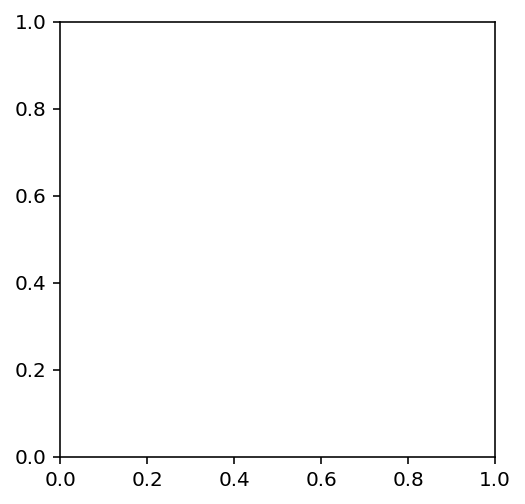

In [229]:
plt.imshow()

In [220]:
zRaster1 = erode(, np.ones(3, dtype = np.uint0).reshape(1,-1))

error: OpenCV(4.2.0) /home/conda/feedstock_root/build_artifacts/libopencv_1577155765823/work/modules/imgproc/src/morph.simd.hpp:756: error: (-213:The function/feature is not implemented) Unsupported data type (=4) in function 'getMorphologyRowFilter'


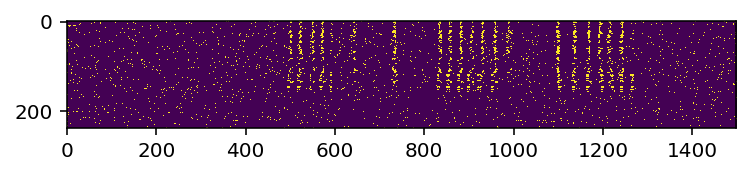

In [213]:
plt.imshow(dilate(zRaster, np.array()))

In [210]:
xcut[] = 

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])